# Memory Augmented Neural Network using Omniglot Dataset

As we showcased that a Neural Turing Machine's controller is capable of using content-based addressing, location-based addressing or both. Whereas, here MANN works on using a pure content-based memory writer. 

MANN also use a new addressing schema called least recently used access. The idea behind the scene is that the least recently used memory location is determined by the read operation and the read operation is performed by content-based addressing. So, we basically perform content-based addressing for reading and write to the location that was least recently used.




[picture credits: MANN Paper(https://arxiv.org/pdf/1605.06065.pdf)]


<img src="mann.png" width="1500"/>

In this tutorial, we will do following things step by step:
1. Data Preprocessing: Creating Pairs.
2. Create a Memory Augmented Neural Network
3. Train it using Omniglot dataset. 

In [1]:
!pip install scipy==1.1.0
!pip install Pillow

You are using pip version 9.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


##### Step1: Lets first import all libraries needed.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils as ut
import os
import time
from scipy.misc import imresize
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

#### Step2 : Load Data

We are reading images from two folders named 'image_background', 'image_evaluation' defined in 'data' directory

Dataset is divided into 1423 charcters images for training and rest for validation

In [3]:
width = 20

# gather data paths
subfolds = ut.extend_children('data','')
datafolds = [subfolds[0],subfolds[1]]
alphabets = ut.extend_generation(datafolds,'')
charpaths = ut.extend_generation(alphabets,'')
chars_dataset = [v.split('/')[2]+'/'+v.split('/')[3] for v in charpaths]

# index-value conversion dictionaries for character set
i2v = {i:v for i, v in enumerate(chars_dataset)}
v2i = {v:i for i, v in enumerate(chars_dataset)}

# get size of dataset
mc_dataset = len(charpaths)
print(mc_dataset,'total character classes')

# train split
mc_train = 1423
chars_train = chars_dataset[:mc_train]
classes_train = [v2i[v] for v in chars_train]

# validation split
mc_val = mc_dataset-mc_train
chars_val = chars_dataset[-mc_val:]
classes_val = [v2i[v] for v in chars_val]



print('%s characters assigned for training, %s characters assigned for validation'%(mc_train,mc_val))

1623 total character classes
1423 characters assigned for training, 200 characters assigned for validation


### Step 3: Read Data

All character images are read and saved in the imgs_dataset variable.

In [4]:
# load images from character paths
imgs_dataset = []
for i, charfold in enumerate(charpaths):
    if i%200==0:
        print('%s/%s character folders loaded'%(i,mc_dataset))
    imgs_dataset.append([ ut.load_image(imgpath,(width,width))/127.5-1 for imgpath in ut.extend_children(charfold,'.png') ] )
# access imgs_dataset [ character index ] [ sample index ] [ row,col ]

# split images between train and validation sets
imgs_train = imgs_dataset[:mc_train]
imgs_val = imgs_dataset[-mc_val:]

0/1623 character folders loaded
200/1623 character folders loaded
400/1623 character folders loaded
600/1623 character folders loaded
800/1623 character folders loaded
1000/1623 character folders loaded
1200/1623 character folders loaded
1400/1623 character folders loaded
1600/1623 character folders loaded


#### Step 4: Let's Initialize our Hyper-paramters

We define all the hyper-parameters and dimensions of all the variables here.
* n_classes is 5 (in each batch we have 5 types of characters)

In [5]:
n_classes = 5
memory_size = 128 # number of features per entry
memory_dim = 40 # number of entries in memory
learning_rate = 1e-3
batch_size = 16

n_inputs = width*width+n_classes # input to LSTM cell.
n_hnodes = 200 # LSTM cell size
n_outputs = n_classes
mem_size = memory_size # number of rows in external memory 
mem_dim = memory_dim # number of columns in external memory
n_reads = 4 # number of heads. 

n_xh = n_inputs+n_hnodes # inputs to LSTM cell (previous state + input image dim)
n_rd = n_reads*mem_dim
n_hr = n_hnodes+n_rd
gamma = 0.95

#### Step 5: Let's Create all Trainable parameters for network and initialize them.

We define all the hyper-parameters and dimensions of all the variables here.

This defines three types of weights:
* LSTM weights (we use LSTM controller, a feed-forward controller could also be used)
* Read and Write key weights
* Output fully connected layer weights

#### Step 6: Define Model

The next cell defines the forward pass of the network. 
It works as follows:
* the net() function receives input X which is sliced along dim 0 which is the time dimension
* we sequentially process each time step in run_one_step() function and collect state vectors of each step's output
* The predictions are made at each time step with fully connected output layer

In [7]:
class MANN:
    def __init__(self):
        print ("MANN Initlaized")
    
    def weight_intialization(self):
        # LSTM gates (4 of them: weights and biases for each)
        W_gf = torch.Tensor(n_xh, n_hnodes).uniform_(-1., 1.).requires_grad_()
        b_gf = torch.Tensor(n_hnodes).uniform_(-1., 1.).requires_grad_()
        W_gi = torch.Tensor(n_xh,n_hnodes).uniform_(-1., 1.).requires_grad_()
        b_gi = torch.Tensor(n_hnodes).uniform_(-1., 1.).requires_grad_()
        W_go = torch.Tensor(n_xh,n_hnodes).uniform_(-1., 1.).requires_grad_()
        b_go = torch.Tensor(n_hnodes).uniform_(-1., 1.).requires_grad_()
        W_u = torch.Tensor(n_xh,n_hnodes).uniform_(-1., 1.).requires_grad_()
        b_u = torch.Tensor(n_hnodes).uniform_(-1., 1.).requires_grad_()
        # Controller Weights
        W_kr = torch.Tensor(n_hnodes,n_rd).uniform_(-1., 1.).requires_grad_()
        b_kr = torch.Tensor(n_rd).uniform_(-1., 1.).requires_grad_()
        W_kw = torch.Tensor(n_hnodes,n_rd).uniform_(-1., 1.).requires_grad_()
        b_kw = torch.Tensor(n_rd).uniform_(-1., 1.).requires_grad_()
        W_ga = torch.Tensor(n_hnodes,n_reads).uniform_(-1., 1.).requires_grad_()
        b_ga = torch.Tensor(n_reads).uniform_(-1., 1.).requires_grad_()
        # logit weights
        W_o = torch.Tensor(n_hr,n_outputs).uniform_(-1., 1.).requires_grad_()
        b_o = torch.Tensor(n_outputs).uniform_(-1., 1.).requires_grad_()
    
    def get_state0(self):
        # memory variables (not trainable.)
        # initialize memory and LSTM states with zero. 
        return(
            torch.FloatTensor(1e-6*np.random.rand(batch_size,mem_size,mem_dim)),
            torch.FloatTensor(np.zeros((batch_size,n_hnodes))),
            torch.FloatTensor(np.zeros((batch_size,n_hnodes))),
            torch.FloatTensor(np.zeros((batch_size,mem_size))),
            torch.FloatTensor(np.zeros((batch_size,n_reads,mem_size))),
            torch.FloatTensor(np.zeros((batch_size,n_reads,mem_dim))),
        )
    
    def run_one_step(self, X_t, state):
        # Run one step of the episode. 
        # This consists of Reading, Writing, and Controller
        M_tm1, h_tm1, c_tm1, wu_tm1, wr_tm1, r_tm1 = state
        X_t_r = X_t.view(-1,n_inputs)
        xh = torch.cat((X_t_r,h_tm1),1)
        gf = torch.sigmoid(torch.matmul(xh,W_gf) + b_gf)
        gi = torch.sigmoid(torch.matmul(xh,W_gi) + b_gi)
        go = torch.sigmoid(torch.matmul(xh,W_go) + b_go)
        u_t = torch.tanh(torch.matmul(xh,W_u) + b_u)
        c_t = c_tm1*gf + u_t*gi
        h_t = c_t*go
        kr_t = torch.tanh(torch.matmul(c_t,W_kr) + b_kr).view(batch_size,n_reads,mem_dim)
        kw_t = torch.tanh(torch.matmul(c_t,W_kw) + b_kw).view(batch_size,n_reads,mem_dim)
        k_norm = torch.norm(kr_t, dim=2, keepdim=True)
        m_norm = torch.norm(M_tm1, dim=2, keepdim=True)
        inner_prod = torch.matmul(kr_t, M_tm1.permute(0,2,1))
        norm_prod = torch.matmul(k_norm, m_norm.permute(0,2,1))
        wr_t = F.softmax(inner_prod/norm_prod)
        wu_1 = wu_tm1*gamma + torch.sum(wr_t, dim=1)
        r_t = torch.matmul(wr_t,M_tm1)
        ga = torch.unsqueeze(torch.sigmoid(torch.matmul(h_t,W_ga)+b_ga),2)
        _, wlu_inds = torch.topk(-1*wu_1,k=n_reads)
        wlu_t = torch.sum(F.one_hot(wlu_inds, mem_size).type(torch.FloatTensor),dim=1,keepdim=True)
        ww_t = wr_t*ga + wlu_t*(1-ga)
        wu_t = wu_1 + torch.sum(ww_t, dim=1)
        M_1 = M_tm1 * (-1*wlu_t).permute(0,2,1)
        M_t = M_1 + torch.matmul(ww_t.permute(0,2,1), kw_t)
        st8_t = (M_t, h_t, c_t, wu_t, wr_t, r_t)
        return st8_t
    
    def net(self, X=None, y=None):
        # X is of shape (batch_size, None, width, width)
        self.weight_intialization()
        a = np.arange(100*16*405).reshape((100,16,405)).astype(np.float32)
        X = torch.from_numpy(a)

        state0 = self.get_state0()
        curr_state = state0

        # Collect output of state vectors in each time step.
        M_f = []
        h_f = []
        c_f = []
        wu_f = []
        wr_f = []
        r_f = []

        for i in range(X.shape[0]):
            curr_state = self.run_one_step(X[i], curr_state)
            M_f.append(curr_state[0])
            h_f.append(curr_state[1])
            c_f.append(curr_state[2])
            wu_f.append(curr_state[3])
            wr_f.append(curr_state[4])
            r_f.append(curr_state[5])

        M_f = torch.stack(M_f)
        h_f = torch.stack(h_f)
        c_f = torch.stack(c_f)
        wu_f = torch.stack(wu_f)
        wr_f = torch.stack(wr_f)
        r_f = torch.stack(r_f)

        hr = torch.cat((h_f, r_f.view(-1,batch_size,n_rd)),2)
        o_f = torch.tensordot(hr,W_o,1)+b_o
        return (M_f, h_f, c_f, wu_f, wr_f, r_f, o_f)




##### Step 7: Initialize optimizer and criteria for  training

We use Adam optimizer on cross entropy loss 

In [8]:
optimizer = optim.Adam([W_gf, b_gf, W_gi, b_gi, W_go, b_go, W_u, b_u, W_kr,b_kr, W_kw, b_kw,
                      W_ga, b_ga, W_o, b_o], lr=learning_rate)
    
criterion = nn.CrossEntropyLoss()

### Prepare graph input

Y-labels predicted at each time step are appended to input at next time step for better signal.
* During training, we have access to y_labels at time step. Shift the y_labels by one time step and append this to the input to prepare input data

In [9]:
def get_graph_input(X_train, y_train):
    X = np.transpose(X_train.reshape(batch_size,-1,width*width),(1,0,2))
    y_labels = np.transpose(y_train, (1,0,2))
    y_labels_shifted = np.concatenate((np.zeros((1,batch_size,n_classes)), y_labels[:-1,:]),0)
    X = np.concatenate((X,y_labels_shifted),-1)
    y = np.argmax(y_labels, -1)
    return torch.from_numpy(X), torch.from_numpy(y)
    

### Let's Run Experiment

In [10]:
n_epochs = 50
loss_values =[]
for epoch in range(n_epochs):
    print('Epoch {} starting..'.format(epoch+1))
    epoch_start = time.time()
    classes_epoch, imgs_epoch = ut.shuffle_xy(classes_train,imgs_train) 

    n_batches = len(classes_epoch)//(n_classes*batch_size)
    total_correct=0
    total_batch=0
    for batch in range(n_batches):
        classes_batch = classes_epoch[batch*n_classes*batch_size:(batch+1)*n_classes*batch_size]
        imgs_batch = imgs_epoch[batch*n_classes*batch_size:(batch+1)*n_classes*batch_size]

        Xl_batch, yl_batch = [], []
        for episode in range(batch_size):
            imgs_ep = imgs_batch[episode*n_classes:(episode+1)*n_classes]
            Xl_ep, yl_ep = [], []
            for ind, cat in enumerate(imgs_ep):
                for arr in cat:
                    Xl_ep.append(arr)
                    yl_ep.append(ut.one_hot(ind,n_classes))
            Xl_shuff, yl_shuff = ut.shuffle_xy(Xl_ep,yl_ep)
            X_arr, y_arr = np.asarray(Xl_shuff), np.asarray(yl_shuff)
            Xl_batch.append(X_arr)
            yl_batch.append(y_arr)
        X_train, y_train = np.asarray(Xl_batch), np.asarray(yl_batch)
        X_mann, y_mann = get_graph_input(X_train, y_train)
        optimizer.zero_grad()
        M, h, c, wu, wr, r, o = net(X_mann)
        outs = o.view(100*16, 5)
        gt = y_mann.view(100*16)
        loss = criterion(outs, gt)
        loss.backward()
        optimizer.step()
        loss_d = loss.item()
        _, predicted = torch.max(outs.data, 1)
        correct = (predicted == gt).sum().item()
        total_correct+=correct
        total_batch+=len(predicted)
        loss_values.append(loss_d)
#         if(epoch%10==0):
#             print('Epoch %d'%(epoch+1),'/ Batch (%d/%d)'%(batch+1,n_batches),'/ Loss %f'%(loss_d))

#     epoch_end = time.time()
#     time_elapsed = epoch_end-epoch_start
#     print('Epoch {} complete,'.format(epoch+1),time_elapsed,'seconds elapsed')
    print('Epoch %d'%(epoch+1))
    print (sum(loss_values)/n_batches)
    print (total_correct*1.0/total_batch)
    

Epoch 1 starting..


/opt/anaconda3/envs/project09/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1
106.89529418945312
0.20022058823529412
Epoch 2 starting..
Epoch 2
183.316676420324
0.1975735294117647
Epoch 3 starting..
Epoch 3
236.93377999698416
0.19897058823529412
Epoch 4 starting..
Epoch 4
276.43969950956455
0.2013235294117647
Epoch 5 starting..
Epoch 5
303.2496592577766
0.20044117647058823
Epoch 6 starting..
Epoch 6
319.4746466243968
0.20268382352941178
Epoch 7 starting..
Epoch 7
328.77172296187456
0.2001470588235294
Epoch 8 starting..
Epoch 8
333.403308097054
0.19375
Epoch 9 starting..
Epoch 9
335.71365515624774
0.19466911764705883
Epoch 10 starting..
Epoch 10
337.55918713878185
0.20091911764705883
Epoch 11 starting..
Epoch 11
339.31427636567287
0.2038970588235294
Epoch 12 starting..
Epoch 12
341.01413709275863
0.20022058823529412
Epoch 13 starting..
Epoch 13
342.697394174688
0.19963235294117648
Epoch 14 starting..
Epoch 14
344.3768786472433
0.19897058823529412
Epoch 15 starting..
Epoch 15
346.05062656542833
0.1998529411764706
Epoch 16 starting..
Epoch 16
347.7195925011

#### Visualizations 

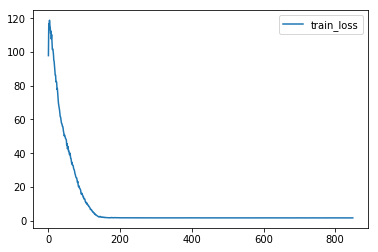

In [11]:
def plot_loss(train,name1="train_loss"):
    plt.plot(train, label=name1)
    plt.legend()

plot_loss(loss_values)